# Assignment 3 - Recommender Systems

##### Student Name: Md Majharul Islam

##### Student ID: stuid218568

##### The Tutorial will take place online on Friday, Jan 22nd 2020 at 11:00am (CET) c.t. <br><br>This Assignment is due on Monday, Dec 18th 2020 at 11:59pm (CET)<br>The next Assignment (Assignment 4) will be published on Jan 26th (so there is a one week break)!

| Total Points | Points Needed To Pass (50%) | Points Reached |
|:-:|:-:|:-----------:|
| 32 | 16 |  |

The main idea to this assignment is learning and applying the concept of recommender systems. Imagine you are part of a company selling video games. You have users and you want to recommend games for these users to buy and play. For this purpose we provide to you with a dataset based on the Steam Game Store.

In [82]:
# First some imports, as always
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD

In [83]:
# Here we import two datasets, that we will later combine into one

steam_user_data = pd.read_csv('steam-200k.csv')
steam_description_data = pd.read_csv('steam_games.csv')

Ok let's take a look at our **steam_user_data** dataset. Each row contains a game (**game**) that was bought and/or played (**action**) by a user (**userid**). For a game that was played we addtionally know how long the user played the game (**hours**). Generally for each entry corresponding to a bought game, we also have an entry with the *play* action, but a user could buy a game, but never play it. Then we have an entry with the *purchase* action, but not an entry with a *play*. The hour field for a *purchase* entry is always 1. Column **other** can be ignored.

In [84]:
steam_user_data.head(5)

,userid,game,action,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


We additionally have the **steam_description_data** set, which contains addtional information about each game. We will only need a few features from this. For example the **genre** of the game or the user-generated **popular_tags**.

In [85]:
small_steam_description_data = steam_description_data[['game', 'genre', 'game_details', 'popular_tags', 'game_description']]
small_steam_description_data.head(3)

,game,genre,game_details,popular_tags,game_description
0,DOOM,Action,"Single-player,Multi-player,Co-op,Steam Achieve...","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","About This Game Developed by id software, the..."
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Action,Adventure,Massively Multiplayer","Multi-player,Online Multi-Player,Stats","Survival,Shooter,Multiplayer,Battle Royale,PvP...",About This Game PLAYERUNKNOWN'S BATTLEGROUND...
2,BATTLETECH,"Action,Adventure,Strategy","Single-player,Multi-player,Online Multi-Player...","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",About This Game From original BATTLETECH/Mec...


We join both datasets on the **game** attribute using pandas merge function.

In [86]:
steam_data = steam_user_data.merge(small_steam_description_data, on='game')
steam_data.head(3)

,userid,game,action,hours,other,genre,game_details,popular_tags,game_description
0,151603712,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
1,151603712,Fallout 4,play,87.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
2,87445402,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."


## 1. Trivial Recommendations

So now we want to use this dataset to find out which one a user should play next. The first idea you might have is to just recommend the most popular titles. Now try to find the 10 most bought games according to our dataset. 

*Hint: Use the pandas groupby function*

### <font color='#782769'>TODO #1: List the 10 most purchased games (2/2 Points)</font>

In [87]:
purchased = steam_data[steam_data['action'] == 'purchase'].groupby("game").count() # TODO (1 Point)
sorted_purchased = purchased.sort_values(by=['action'], ascending=False) # TODO (1 Point)
sorted_purchased[["action"]].head(10)

,action
game,
Dota 2,4841
Team Fortress 2,2323
Unturned,1563
Left 4 Dead 2,951
Counter-Strike,856
Warframe,847
Garry's Mod,731
Robocraft,689
Heroes & Generals,658


Now these might be the most bought games, but not the most played games. There might be games that users buy, but not really play. Also games with a high avg playing time might mean, that users tend to like the game. Now try to find the 10 games with the longest avg playtime per user.

*Hint: Don't forget to select only the entries that contain played games*

### <font color='#782769'>TODO #2: List the 10 games with the highest avg hours played (2/2 Points)</font>

In [88]:
played_game = steam_data[steam_data['action'] == 'play']
played = played_game.groupby('game')[['hours']].mean() # TODO (1 Point)
sorted_by_playtime = played.sort_values(by=['hours'], ascending=False) # TODO (1 Point)
sorted_by_playtime[["hours"]].head(10)

,hours
game,
Eastside Hockey Manager,1295.000000
Perpetuum,400.975000
Freaking Meatbags,331.000000
Counter-Strike,236.375176
Avernum 4,228.000000
Dota 2,202.785499
Europa Universalis IV,195.180000
Cultures - Northland,194.000000
Uncharted Waters Online,181.000000


This might actually have a slight problem. For example, WTF is 'Eastside Hockey Manager' and why does it have an average playing time of over 1000 hours. In order to migitage that some games might only be bought by very few users, that then play it a long time, let's weight the avg playtime by the percentage of users that play this game.

### <font color='#782769'>TODO #3: Multiply each avg hours with the ratio of users playing the game and users overall! (4/4 Points)</font>

In [89]:
# create ratio column (1 Point)
total_players_count = len(played_game.index) 
players_per_game = played_game.groupby('game').count().sort_values(by=['userid'], ascending=False)
df_ratio = players_per_game[['userid']] / total_players_count 
df_played = pd.DataFrame(played) # used from TODO#2 before
df_ratio

# join with average playtimes from above, multiplication with average hours and get top 10 (3 Points)
df_tmp = df_played.join(df_ratio).rename(columns={'hours': 'avg_hours'})
df_tmp['playtime_user_ratio'] = df_tmp['avg_hours'] * df_tmp['userid']# TODO (1 Point)
sorted_by_playtime_user_ratio = df_tmp.sort_values(by=['playtime_user_ratio'], ascending=False) # TODO (1 Point)
sorted_by_playtime_user_ratio.head(10) # TODO (1 Point)

,avg_hours,userid,playtime_user_ratio
game,,,
Dota 2,202.785499,0.133519,27.075726
Team Fortress 2,74.762505,0.064070,4.790063
Counter-Strike,236.375176,0.015666,3.703039
Garry's Mod,74.662613,0.018369,1.371468
Left 4 Dead 2,41.943446,0.022092,0.926627
Terraria,65.112609,0.012687,0.826097
Warframe,63.855189,0.011694,0.746741
Arma 3,153.221019,0.004330,0.663477
Grand Theft Auto V,85.340892,0.007419,0.633166


Now that should look like a pretty decent list of popular games on Steam from 4 years ago, when this dataset was collected. These lists might seem like a good starting point for a new user, but for old users we want to recommend games tat fit a user's preferences. So the first thing we can do is to look at the obvious features of the games that a user likes, e.g. genre, tags etc. and try to find similiar games with similiar features.

In [90]:
steam_data.head()

,userid,game,action,hours,other,genre,game_details,popular_tags,game_description
0,151603712,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
1,151603712,Fallout 4,play,87.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
2,87445402,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
3,87445402,Fallout 4,play,83.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
4,25096601,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."


## 2. Content-Based Recommendation

So let us imagine we have a user that really loves the rougelite rythm dungeon crawler *Crypt of the NecroDancer* (https://store.steampowered.com/app/247080/Crypt_of_the_NecroDancer/) Your task is now (in increasingly complicated and mathy ways) to find similiar games to it. We will begin by using the Jaccard Similarity measure and the **popular_tags** feature. The user generated tags should tell us a lot about what the content of the games are and just by comparing which games have simliar sets of tags should already give us a good collection of simliar games.

### <font color='#782769'>TODO #4: Group the steam_data by game and select only the **popular_tags** for each game (2/2 Points)</font>

In [91]:
tag_data = steam_data.groupby(['game'], sort=False)['popular_tags'].max() # TODO (1 Point)
tag_data.head(10)


game
Fallout 4            Open World,Post-apocalyptic,Exploration,Single...
Left 4 Dead 2        Zombies,Co-op,FPS,Multiplayer,Shooter,Action,O...
HuniePop             Nudity,Mature,Anime,Sexual Content,Dating Sim,...
Path of Exile        Free to Play,Action RPG,Hack and Slash,RPG,Mul...
Poly Bridge          Building,Simulation,Physics,Puzzle,Singleplaye...
Left 4 Dead          Zombies,Co-op,FPS,Multiplayer,Action,Shooter,O...
Team Fortress 2      Free to Play,Multiplayer,FPS,Shooter,Action,Cl...
Tomb Raider          Adventure,Action,Female Protagonist,Third Pers...
The Banner Saga      RPG,Turn-Based,Strategy,Tactical,Turn-Based St...
BioShock Infinite    FPS,Story Rich,Action,Singleplayer,Steampunk,A...
Name: popular_tags, dtype: object

*Encode the genre feature with One-Hot-Encoding by using panda's str.get_dummies(seperator) (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.get_dummies.html) function*


In [92]:
tag_dummies = pd.Series(tag_data).str.get_dummies(sep=',') # TODO (1 Point)
tag_dummies.head(20)

,1980s,1990's,2.5D,2D,2D Fighter,3D,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
game,,,,,,,,,,,,,,,,,,,,,
Fallout 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Left 4 Dead 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
HuniePop,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Path of Exile,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Poly Bridge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Left 4 Dead,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Team Fortress 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tomb Raider,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Banner Saga,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### <font color='#782769'>TODO #5: Calculate the pairwise jaccard distances between each game using our popular tags dummies using sklearn's pairwaise distance function (1/1 Points)</font>

*Hint: When dealing with binary data the jaccard distance (1 - jaccard simliarity) is actually equivalent to the hamming distance. Check the trivial example below and get familiar with the method pairwise_distances and hamming distance first. How would you calculate by hand?* 

In [93]:
matrix = np.array([
    [0,1,1,0],
    [0,1,1,1],
    [0,0,0,0]]
)
row_similarity_distances = pairwise_distances(matrix, metric = "hamming") # pairw... #TODO 
row_similarity_distances

array([[0.  , 0.25, 0.5 ],
       [0.25, 0.  , 0.75],
       [0.5 , 0.75, 0.  ]])

In [94]:
# Calculate the pairwise jaccard distances between each game using our popular tags dummies 

jac_dist = 1 - pairwise_distances(tag_dummies, metric = "hamming") # TODO (1 Point)
jac_dist 
#jac_sim = pd.DataFrame(jac_dist, index=tag_dummies.index, columns=tag_dummies.index)
#jac_sim

array([[1.        , 0.93258427, 0.91573034, ..., 0.93258427, 0.92134831,
        0.94101124],
       [0.93258427, 1.        , 0.89325843, ..., 0.93820225, 0.91573034,
        0.93539326],
       [0.91573034, 0.89325843, 1.        , ..., 0.93258427, 0.92696629,
        0.91292135],
       ...,
       [0.93258427, 0.93820225, 0.93258427, ..., 1.        , 0.96067416,
        0.95224719],
       [0.92134831, 0.91573034, 0.92696629, ..., 0.96067416, 1.        ,
        0.92977528],
       [0.94101124, 0.93539326, 0.91292135, ..., 0.95224719, 0.92977528,
        1.        ]])

### <font color='#782769'>TODO #6: Now write a funtion that takes an arbitrary distance matrix, a list of games that are possible, the game title we are looking for and a value k and returns the k closest games according to the distance matrix (4/4 Points)</font>

*Hint: Try using numpy's argsort function and don't forget to not count the queried game itself*

In [95]:
def getTopKSimiliarGames(distances: np.array, games: list, game: str, k: int):
    
    anchor_game_idx = games.index(game)
    
    #TODO START:
    
    game_score = distances[anchor_game_idx]
    top_k_game_position = game_score.argsort()[::-1][0:k]
    
    top_k_similar_games = [games[i] for i in top_k_game_position]
    
    #TODO END
    
    return top_k_similar_games

Now let's use your function to find the top-10 most simliar games to 'Crypt of the NecroDancer'

In [96]:
getTopKSimiliarGames(jac_dist, list(tag_data.index), 'Crypt of the NecroDancer', 10)


['Crypt of the NecroDancer',
 'Diehard Dungeon',
 "A Wizard's Lizard",
 'Deep Dungeons of Doom',
 'Crawl',
 'Castle In The Darkness',
 'Legend of Dungeon',
 'Dungeon Siege III',
 'Tiny Barbarian DX',
 'bit Dungeon II']

Now that already looks like a decent list of recommendations for someone who likes Dungeon Crawlers. But if we look at a user we actually know more than just one game they like. We need a way to combine the features of multiple games into a single query, so that we find the games that are most simliar to the ones the user likes.

We can combine the recommendations for several games (the ones a user played) by using TF/IDF and Cosine Distance. TF is the term frequency, which in this case means how often a tag is included in the games that a single user plays and it is compared with the IDF. IDF is the Indirect Document Frequency and in our case this is the count of all tag over all documents divided by the occurance of a single tag in all documents.

### <font color='#782769'>TODO #7: Use the tag_dummies table to calculate the inverse Document Frequency for each tag using the follwing function, with N being the number of games and n_t being the occurence of a the queried tag overall documents: (4/4 Points)</font>

*TODO: Use the tag_dummies table to calculate the inverse Document Frequency for each tag using the follwing function, with N being the number of games and n_t being the occurence of a the queried tag overall documents:*
$$ \log_{10}\frac{N}{n_t}$$

In [97]:
import math

def get_idf(term, terms, documents, occurancies):
    
    # TODO START (3 Points)
    
    N = len(games) # lenth of documents
    
    term_index = terms.index(term)
    
    # select and filter occurrences for given term
    term_occurrences = list(filter(lambda x: x > 0, occurancies[:,term_index]))
    n_t = len(term_occurrences) # number of occurance for given term
    
    # idf for given term
    term_idf = math.log10(N/n_t)
    
    # TODO END
    
    return term_idf

    
games = list(set(list(tag_dummies.index)))
popular_tags = list(tag_dummies.columns)

get_idf(term='2.5D', terms=popular_tags, documents=games, occurancies=tag_dummies.values)

1.953364259429403

In [98]:
tag_idfs = [get_idf(term, popular_tags, games, tag_dummies.values) for term in popular_tags]
tag_idfs

[2.1818435879447726,
 1.6425744264762656,
 1.953364259429403,
 0.6493832140285398,
 1.97356764551769,
 2.3415444308122844,
 1.9340591042340165,
 2.0653380188733355,
 1.662318484672023,
 1.97356764551769,
 2.4506889002373526,
 3.295786940251609,
 2.040514435148303,
 0.25796218966326745,
 1.426555220520633,
 2.0916669575956846,
 1.6425744264762656,
 0.35278734688556884,
 2.3415444308122844,
 1.739484439484322,
 2.2166056942039845,
 2.4506889002373526,
 2.2166056942039845,
 1.1851972299523603,
 1.0502742724374594,
 2.040514435148303,
 3.295786940251609,
 2.5968169359155904,
 3.295786940251609,
 2.693726948923647,
 0.71486196457599,
 3.295786940251609,
 2.9947569445876283,
 1.7906369619317033,
 3.295786940251609,
 2.693726948923647,
 2.9947569445876283,
 3.295786940251609,
 1.7275852161846144,
 1.7160033436347992,
 2.693726948923647,
 2.818665685531947,
 2.040514435148303,
 1.97356764551769,
 2.9947569445876283,
 1.2787536009528289,
 1.6236890823158918,
 2.3415444308122844,
 2.181843587944

*TODO: Replace all the 1 entries in the tag_dummies table with the corresponding idf value, resulting in a new vector space for our games*

*Hint: Try multiplying each column with the corresponding value by multiplying each row vector with tag_idfs vector - but without the usage of df.values or numpy in order to avoid floating point errors* 

In [99]:
tag_idf_embedding = pd.DataFrame()

tag_idf_embedding = tag_dummies * tag_idfs # TODO (1 Point)
tag_idf_embedding

,1980s,1990's,2.5D,2D,2D Fighter,3D,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
game,,,,,,,,,,,,,,,,,,,,,
Fallout 4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Left 4 Dead 2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.242708,0.0
HuniePop,0.0,0.0,0.0,0.649383,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Path of Exile,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Poly Bridge,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wooden Sen'SeY,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
SAMURAI WARRIORS 4-II,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Warriors & Castles,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Then let's calculate the pairwise cosine distances and apply our topk function again.

In [100]:
idf_distances = pairwise_distances(tag_idf_embedding, metric = "cosine")

In [101]:
getTopKSimiliarGames(idf_distances, list(tag_data.index), 'Crypt of the NecroDancer', 10)

['Farm Machines Championships 2014',
 'Saw',
 'AstroPop Deluxe',
 'Hammer Heads Deluxe',
 'Talismania Deluxe',
 'Big Money! Deluxe',
 'Amazing Adventures Around the World',
 'World Basketball Tycoon',
 'BattleSpace',
 'Spriter Pro']

Interestingly enough, now you might see that a few Rythm Style games have found their way to the top. NecroDancer is a rougelike dungeon crawler and a rythm game. So  there are less rythm games than dungeon crawlers on steam and therefore the tags that concern the rythm part of the game are weighted more than the dungeon tags. And that is excactly the idea behind idf! We want to lessen the importance of more frequently used words, e.g. in language this would mean that words like 'the' and 'and' are explicitly embedded as less important than very words that are specific to a document. 

## 3. Collaborative Filtering

What we did up till now is often refered to as *Content-Based Recommendation*. This means we use the features of the items that a user likes or has interacted with (in this case video games) to find similiar items that this user might like. That means we do not use information about other user than the target. What we can also do is use the preferences of other users to recommend games to our target user.

And that is what *Collaborative Filtering* Recommender Systems try to do. In our case the information about games based upon other users is encoded in the **action** feature. We can look at this feature as a sort of user rating of a game. We assume that if someone bought a game they found it interesting enough and if they then played it a lot they they even liked the game. From this we want to create a matrix. 

### <font color='#782769'>TODO #8: First create a ratings matrix that has a 1 if a user bought a game and a 0 if they did not buy it. (3/3 Points)</font>

*Hint: Use the pandas function pivot_table (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)*

In [102]:
purchased = steam_data.copy()
purchased['purchased'] = np.where(purchased.action == 'purchase', 1, 0) # TODO  (1 Point)
ratings_table = pd.pivot_table(purchased, values='purchased', index=['userid'],
                               columns='game', aggfunc=np.sum, fill_value=0) # TODO  (1 Point)
ratings_table

game,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,140,16bit Trader,1954 Alcatraz,3 Stars of Destiny,3DMark,3DMark 11,...,iRacing,ibb & obb,in Space,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,resident evil 4 / biohazard 4,rymdkapsel,samurai_jazz
userid,,,,,,,,,,,,,,,,,,,,,
5250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309404240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309434439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309812026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Another possibility would be to user the played hours as a rating, for example by fitting a histogram with 5 buckets (or even a mixture of gaussians with 5 functions) to the **hours** feature and using this as a rating vom 1 - 5 'stars'. This is also completely reasonable and if you want you can try it out, but we will continue with the purchase information + confidence model.

Let us take a closer look at our ratings matrix. What attributes can we gather from it?

*TODO: Calculate the percentage of 1 entries in the matrix*

In [103]:
sparsity = (np.count_nonzero(ratings_table) / ratings_table.size) # TODO (1 Point)
print('{:.2%} of the user-item matrix is filled'.format(sparsity))

0.28% of the user-item matrix is filled


As you can see most of our table is empty. This means our matrix is very sparse! Which makes sense since this is in the title of your Assigment ;).

### 3.1 Trivial Calculations

So far our matrix had a row for each users showing us, but if we now transpose our matrix, we can have new features (users) for each of our games. 

In [104]:
ratings_table.T

userid,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,309213952,309216884,309228590,309262440,309265377,309404240,309434439,309812026,309824202,309903146
game,,,,,,,,,,,,,,,,,,,,,
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Second Ninja,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"10,000,000",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100% Orange Juice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rFactor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rFactor 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
resident evil 4 / biohazard 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# From now on we will use numpy instead of pandas, because some calculations 
# are easier done with numpy arrays instead of DataFrames
# Here is how to convert a pandas df to a numpy array
ratings_matrix = ratings_table.values
# Well that was easy:
ratings_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We can use now the resulting feature space to find simliar games again:

In [106]:
# use sklearn pairwise distance to calculte the cosine distances 
trivial_cos_distances = pairwise_distances(ratings_matrix.T, metric='hamming')

In [107]:
trivial_cos_distances

array([[0.        , 0.00128205, 0.00078895, ..., 0.00285996, 0.00078895,
        0.00078895],
       [0.00128205, 0.        , 0.00069034, ..., 0.00276134, 0.00069034,
        0.00069034],
       [0.00078895, 0.00069034, 0.        , ..., 0.00246548, 0.00019724,
        0.00019724],
       ...,
       [0.00285996, 0.00276134, 0.00246548, ..., 0.        , 0.00246548,
        0.00246548],
       [0.00078895, 0.00069034, 0.00019724, ..., 0.00246548, 0.        ,
        0.00019724],
       [0.00078895, 0.00069034, 0.00019724, ..., 0.00246548, 0.00019724,
        0.        ]])

Now again let's Use your getTopKSimiliarGames function to find the 10 most similiar games to Crypt.

In [108]:
getTopKSimiliarGames(trivial_cos_distances, list(ratings_table.columns), 'Crypt of the NecroDancer', 10)

['Dota 2',
 'Team Fortress 2',
 'Unturned',
 'Left 4 Dead 2',
 'Counter-Strike',
 'Warframe',
 "Garry's Mod",
 'Robocraft',
 'Heroes & Generals',
 'Half-Life 2']

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

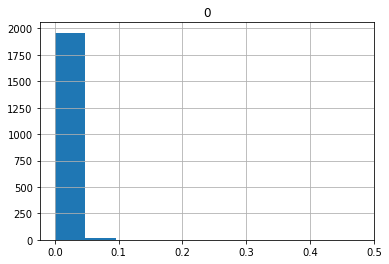

In [109]:
# Well that's actually not the worst result. Let's look at the distribution  
# our distances

game_index = list(ratings_table.columns).index('Crypt of the NecroDancer')
distances_to_game = trivial_cos_distances[game_index]

pd.DataFrame(distances_to_game).hist()

As you can see these distances are not distributed well. Which is excactly the problem with such sparse vector spaces. And if you listened to the lecture you might know what this calls for. Dimensionality Reduction with ...

### 3.2 SVD

So we can assume that there is some underlying factors that lead to users buying certain games. We do not know these attributes and therefore they are often refered to as *hidden features*, *latent features* or *embeddings*. We can assume that this latent space has a significantly lower dimensionality than our ratings_matrix. One way to find these features is to use the Matrix Factorization to create two low dimensional matrices that multiply to our ratings matrix. This can be seen as a kind of compression. One classic MF is SVD. In this case we want to reduce the dimensionality so we use truncated svd.

### <font color='#782769'>TODO #9: Explore the ideal number of components for usage of SVD and determine the top k similar games based on the combined svd_cos_distnaces and idf_distances. (4/4 Points)</font>

*Hint: Use sklearn.decomposition.TruncatedSVD (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to create a new lower rank matrix. Start by using a high number of components (ca. 100) and look at the explained variance ratio. Use this information to find a reasonable number of dimensions after which the variance ratio drops below 0.01. The TruncatedSVD Functions is sometimes a bit unstable. If you get a weird error, just run the cell again until it runs through*

In [110]:
from sklearn.decomposition import TruncatedSVD

metrics = {
    'comps': [],
    'avg_var_ratio': [],
    'usv': []
}
avg = 0
steps = 1
components = 100

#TODO START
while avg < 0.01:
    if components % 5 == 0:
        svd = TruncatedSVD(n_components=components)
        latent_matrix = svd.fit_transform(ratings_table.T)
        avg = svd.explained_variance_ratio_.mean()
        
        #print(latent_matrix.shape)
        
        metrics['comps'].append(components)
        metrics['avg_var_ratio'].append(avg)
        metrics['usv'].append(latent_matrix)
        
        print(f"comps={components} avg_var_ratio={avg}")
    components-=steps
#TODO END

sufficient_num_comps = int(pd.DataFrame(metrics).tail().iloc[-2:-1,0])
print(f"sufficient_num_comps={sufficient_num_comps}") 

usv = pd.DataFrame(metrics).tail().iloc[-2:-1,2].ravel()[0]

comps=100 avg_var_ratio=0.007227650251527209
comps=95 avg_var_ratio=0.007504118496020927
comps=90 avg_var_ratio=0.007801887728982674
comps=85 avg_var_ratio=0.008130493700421978
comps=80 avg_var_ratio=0.008490675885140141
comps=75 avg_var_ratio=0.008889820218476114
comps=70 avg_var_ratio=0.009336522921792142
comps=65 avg_var_ratio=0.009840052292780774
comps=60 avg_var_ratio=0.010414145398479306
sufficient_num_comps=65


*Use pairwise cosine distance on the reduced game vectors*

In [111]:
svd_cos_distances = pairwise_distances(usv, metric='cosine')

And we run our function to search similiar games to 'Crypt of the Necrodancer' again

In [112]:
getTopKSimiliarGames(svd_cos_distances, list(ratings_table.columns), 'Crypt of the NecroDancer', 10)

['Trucks & Trailers',
 'Bus Driver',
 'Fair Strike',
 'After All',
 'Zen of Sudoku',
 'Towtruck Simulator 2015',
 'Pro Cycling Manager 2015',
 'Tree of Life',
 'HIS (Heroes In the Sky)',
 'Super Sanctum TD']

And now you might see that this not as easily comprehensible than using the explicit tag feature. As already stated we do not know what leads to the buying habits of the users, so we have to trust that there is some hidden relation between these games. But we can look at the distance distribution again to see whether our latent space is useful and it looks much better this time. There are some games very close to our target, some that are very far away, but most 

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

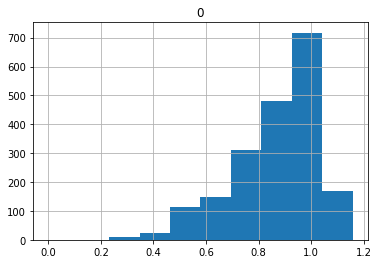

In [113]:
game_index = list(ratings_table.columns).index('Crypt of the NecroDancer')
distances_to_game = svd_cos_distances[game_index]

pd.DataFrame(distances_to_game).hist()

Now let's combine both the text features and the user features to find the best games for our test users again!

*Hint: First we need to make sure that both of our distances are in the same value range. So use sklearn.preprocessing.normalize to norm both svd_cos_distances and idf_distances to [0, 1] and then take the mean of each value in both lists*

In [114]:
from sklearn.preprocessing import normalize

svd_cos_distances_norm = normalize(svd_cos_distances)
idf_distances_norm = normalize(idf_distances)
combined_distances = pd.concat([pd.DataFrame(svd_cos_distances_norm),pd.DataFrame(idf_distances_norm)],axis=1).groupby(level=0,axis=1).mean() # TODO (1 Point)

And another call to our function:

In [115]:
getTopKSimiliarGames(combined_distances, list(ratings_table.columns), 'Crypt of the NecroDancer', 10)

['FlatOut',
 'Super Sanctum TD',
 'Rise of Flight United',
 'Chaos Domain',
 'Kingdom Elemental',
 'AirBuccaneers',
 'Incoming Forces',
 'Praetorians',
 'GT Legends',
 'Company of Heroes 2']

array([[<AxesSubplot:title={'center':'391'}>]], dtype=object)

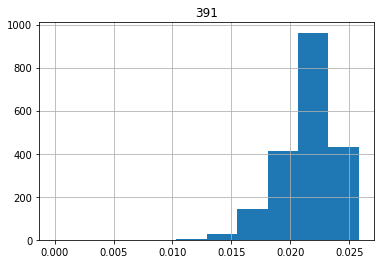

In [116]:
game_index = list(ratings_table.columns).index('Crypt of the NecroDancer')
distances_to_game = combined_distances[game_index]

pd.DataFrame(distances_to_game).hist()

Now this actually looks like a very good collection of games for some one who likes Crypt of the NecroDancer. 
We did our job and we could stop here, but it is always good to try a lot of different approaches and models. Also we still have not actually recommened games tailored to a single user. We could now use the svd matrix to reconstruct our original matrix and check whether we get some new entries for users, but since the results from svd actually allow for negative matrix entrices in the Factor Matrices we did not really learn anything. There are way more Facorizations with negative values, than if we restrict our factor matrices to be Non Negative. And that is our last step:  

### 3.3 Non Negative Matrix Factorization

So SVD is nice enough, but there is other ways to find good latent features for our games, and thereby hopefully make even better recommendations. If you want you can also try out CUR, but we will end this assignment by doing Non Negative Matrix Factorization using numpy. Finally some actual Machine Learning!

### <font color='#782769'>TODO #10: Explore new game recommendations by using doing Non Negative Matrix Factorization. (6/6 Points)</font>

*Hint: Using only numpy and Two Block Coordinate Descent: Given the ratings matrix $X \in \mathbb{R}_+^{n \times d}$ and a latent dimensionality $k$, find two non-negative matrices $W \in \mathbb{R}_+^{n \times k}$ and $H \in \mathbb{R}_+^{k \times d}$ such that $X - WH$ minimizes the Frobenius Norm (Basically another term for the euclidean distance, just as a matrix norm, https://mathworld.wolfram.com/FrobeniusNorm.html). You are given the algorithm and the update formulars for both matrices.

Hint: @ is the short hand for matrix multiplication with numpy. For example W @ H*

#### Two Block Coordinate Descent

1. Init $W^{(0)} \in [0,1]$ and $H^{(0)} \in [0,1]$
2. For t in 1...epochs:
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$W^{(t)} = \text{update}(X, H^{(t-1)}, W^{(t-1)})$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$H^{(t)} = \text{update}(X, W^{(t)}, H^{(t-1)})$
5. End For


 * **Loss Function** $$ L(W, H) = \frac{1}{2} || X - WH ||_F^2 $$
 ---
 * **Update Rule for W**: $$ W \leftarrow W \times \frac{XH^T}{WHH^T} $$
 ---
 * **Update Rule for H**: $$ H \leftarrow H \times \frac{W^TX}{W^TWH} $$

*TODO Step 1: Initialize $W$ and $H$*

In [117]:
np.random.seed(42)

# TODO (1 Point)

embedding_dim = usv.ndim # TODO: Set the latent dimensionality that you found using the SVD
X = ratings_matrix

W = np.random.rand(len(X),embedding_dim) # TODO: Randomly initialize W with positive values
H = np.random.rand(embedding_dim,len(X[0])) # TODO: Randomly initialize H with positive values
print(W.shape)
print(H.shape)
print(X.shape)

(10140, 2)
(2, 1976)
(10140, 1976)


*TODO Step 2: Define the Loss function (Frobenius norm)*

In [118]:
loss = lambda X, WH: (np.linalg.norm((X - WH),'fro'))/2 # TODO (1 Point)

In [119]:
# Just a list to collect the losses for each epoch
losses = []

*TODO: Step 3: Here you have an emtpy loop for your 2-Block Coord Descent.*

*Hint: Make sure that $W$ and $H$ do not contain actual zero values or values that are so low that they create an integer underflow, for example by using numpy's where function!*

In [120]:
from tqdm.notebook import tqdm

epochs = 100
for e in range(epochs):
    
    eps = 1e-15 # the values in matrices W and H should not be lower than eps
    
    # TODO START
    # (1 Point)
    W = np.where(W > eps, W, eps) # Make sure you have only non-zero values by using eps as lower bound
    H = np.where(H > eps, H, eps) # Make sure you have only non-zero values by using eps as lower bound
    
    # (1 Point)
    
    XH = X.dot(H.T)
    WHtH = W.dot(H.dot(H.T))
    W *= XH
    W /= WHtH # update W
    
    XtW = np.dot(W.T, X)
    HWtW = np.dot(W.T.dot(W), H )
    H *= XtW
    H /= HWtW # update H
    
    # (1 Point)
    WH = np.dot(W,H) # reconstruct X
    
    # TODO END
    
    single_loss = loss(X, WH)
    
    if e % 10 == 0:
        print(f'Epoch: {e}, Loss: {single_loss}')
    
    losses.append(single_loss)

Epoch: 0, Loss: 112.42946487836187
Epoch: 10, Loss: 105.74377007634394
Epoch: 20, Loss: 105.67452686546513
Epoch: 30, Loss: 105.67215821443791
Epoch: 40, Loss: 105.66991520110382
Epoch: 50, Loss: 105.66971845608674
Epoch: 60, Loss: 105.66965015315046
Epoch: 70, Loss: 105.6696212204509
Epoch: 80, Loss: 105.66960806833858
Epoch: 90, Loss: 105.66960189735708


Ok, let's take a look at our losses. It should start high, shortly go higher and then go straight done until it does not really change anymore:

<AxesSubplot:>

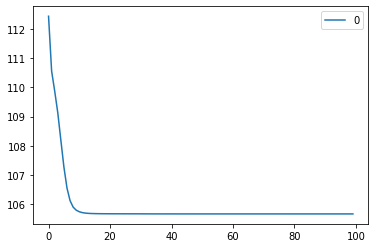

In [121]:
pd.DataFrame(losses).plot()

Your final loss after 250 epochs can be ~0.0015 in case of using mean to reduce the loss function.

In [122]:
loss(X, W @ H)

105.66959907553793

Now we reconstruct X

In [123]:
X_pred = W @ H

*TODO: Create a new ratings matrix by replacing each value lower than 0.1 by a 0 and each other value with a 1. Hint: Use numpy's where function*

In [124]:
new_ratings = np.where(X_pred < 0.1, 0, 1) # TODO (1 Point)

In [125]:
new_ratings

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Now we can make a new ratings table

In [126]:
new_ratings_table = pd.DataFrame(new_ratings, index=ratings_table.index, columns=ratings_table.columns)

Let us pick a user and check out what we would recommend to them:

In [127]:
old_games = steam_data[steam_data['userid'] == 5250]['game']
new_recommendations = new_ratings_table.iloc[0][new_ratings_table.iloc[0] == 1].index
new_recommendations

Index(['Alien Swarm', 'Arma 2', 'Bastion', 'BioShock Infinite',
       'Borderlands 2', 'Company of Heroes', 'Counter-Strike', 'Day of Defeat',
       'DayZ', 'Dead Space', 'Deathmatch Classic', 'Dishonored',
       'Don't Starve', 'Dota 2', 'Far Cry 3', 'Garry's Mod',
       'Grand Theft Auto III', 'Grand Theft Auto IV', 'Grand Theft Auto V',
       'Half-Life', 'Half-Life 2', 'Heroes & Generals', 'Insurgency',
       'Just Cause 2', 'Killing Floor', 'LIMBO', 'Left 4 Dead',
       'Left 4 Dead 2', 'Magicka', 'Natural Selection 2', 'Orcs Must Die! 2',
       'PAYDAY 2', 'Path of Exile', 'PlanetSide 2', 'Portal', 'Portal 2',
       'Ricochet', 'Robocraft', 'Saints Row IV', 'Sniper Elite V2',
       'Super Meat Boy', 'Team Fortress 2', 'Team Fortress Classic',
       'Terraria', 'The Binding of Isaac', 'Tomb Raider', 'Torchlight II',
       'Trove', 'Unturned', 'War Thunder', 'Warface', 'Warframe'],
      dtype='object', name='game')

This is what this user purchased before:

In [128]:
set(old_games)

{'Alien Swarm',
 'Counter-Strike',
 'Day of Defeat',
 'Deathmatch Classic',
 'Dota 2',
 'Half-Life',
 'Half-Life 2',
 'Portal',
 'Portal 2',
 'Ricochet',
 'Team Fortress 2',
 'Team Fortress Classic'}

And here are the games that are new, i.e. the ones that we recommend to this user:

In [129]:
set(new_recommendations) - set(old_games)

{'Arma 2',
 'Bastion',
 'BioShock Infinite',
 'Borderlands 2',
 'Company of Heroes',
 'DayZ',
 'Dead Space',
 'Dishonored',
 "Don't Starve",
 'Far Cry 3',
 "Garry's Mod",
 'Grand Theft Auto III',
 'Grand Theft Auto IV',
 'Grand Theft Auto V',
 'Heroes & Generals',
 'Insurgency',
 'Just Cause 2',
 'Killing Floor',
 'LIMBO',
 'Left 4 Dead',
 'Left 4 Dead 2',
 'Magicka',
 'Natural Selection 2',
 'Orcs Must Die! 2',
 'PAYDAY 2',
 'Path of Exile',
 'PlanetSide 2',
 'Robocraft',
 'Saints Row IV',
 'Sniper Elite V2',
 'Super Meat Boy',
 'Terraria',
 'The Binding of Isaac',
 'Tomb Raider',
 'Torchlight II',
 'Trove',
 'Unturned',
 'War Thunder',
 'Warface',
 'Warframe'}

Ok now you yourself can decide whether those are some good recommendations or not :P And that's it for this Assignment. I hope it was interesting and fun :)